In [1]:
# We want to load all experiments together into one big dataframe of this shape:
# [ "gsm8k" : ["Llama-3.1-8B-Instruct" : { <experiment_data> },
#               "Qwen-3" : { <experiment_data> }],
#    "creative_writing" : ["Llama-3.1-8B-Instruct" : { <experiment_data> }, 
#                           "Qwen-3" : { <experiment_data> }]
# ]

# And each experiment_data has this shape:
# [ "prompt0" : { <prompt_data> },
#    "prompt1" : { <prompt_data> }
# ]

# And each prompt_data has this shape:
# {
#  "top_p_tokens" : [ <list of lists of top p token ids> ],
#  "top_p_probs"  : [ <list of lists of top p token probabilities (after softmax)> ],
#  "top_p_logits" : [ <list of lists of top p token logits (before softmax)> ],
#  "top_p_generated_tokens" : [ <list of lists of top p tokens decoded> ],
#  "top_p_entropies" : [ <list of entropies of top p tokens> ],
#  "full_entropies"  : [ <list of entropies over full distribution> ],
#   "prompt" : "<prompt that was used>",
#  "correct" : "<did the model answer correct (for math questions)"
# }
# We nedd top_p_tokens
# We dont need top_p_probs (they can be calculated from top_p_logits via softmax)
# We dont need top_p_logits (because we dont look at those for now)
# We dont need top_p_generated_tokens (they can be decoded from top_p_tokens)
# we dont need top_p_entropies (we want to explore full entropy!)
# We need full_entropies, because we cant save all 32k logits to calculate it later.
# we need prompt
# we dont need correct (for now we dont care about that)

#dict_keys(['top_p_tokens', 'top_p_probs', 'top_p_logits', 'generated_tokens', 'entropies', 'cosines', 'prompt', 'correct'])

In [20]:
# Dict[str, Dict[str, List[Dict[str, Tensor]]]]
# dataset_name -> model_name -> list of entries

import os
import torch

# Final structure:
# Dict[str, Dict[str, Dict[str, Any]]]
# results[dataset_name][model_name] = {
#     "file_contents": <string from txt file>,
#     "data": <list of dicts with tensors from .pt>
# }

import numpy as np

def load_results(results_root="results"):
    results = {}

    for dataset_name in os.listdir(results_root):
        dataset_path = os.path.join(results_root, dataset_name)
        if not os.path.isdir(dataset_path):
            continue

        results[dataset_name] = {}

        for model_name in os.listdir(dataset_path):
            model_path = os.path.join(dataset_path, model_name)
            if not os.path.isdir(model_path):
                continue

            pt_files = [f for f in os.listdir(model_path) if f.endswith(".pt")]
            txt_files = [f for f in os.listdir(model_path) if f.endswith(".txt")]

            if not pt_files:
                continue
            if len(pt_files) > 1:
                raise ValueError(f"Multiple .pt files in {model_path}, expected only one.")
            if len(txt_files) != 1:
                raise ValueError(f"Expected exactly one .txt file in {model_path}, found {len(txt_files)}.")

            pt_path = os.path.join(model_path, pt_files[0])
            txt_path = os.path.join(model_path, txt_files[0])

            data = torch.load(pt_path)
            with open(txt_path, "r") as f:
                file_contents = f.read()

            results[dataset_name][model_name] = {
                "hf_model_name": file_contents,
                "data": data
            }

    return results


pearson coefficient
-0.5755677712389228
0.0
Spearman coefficient
-0.7046207864401464
0.0


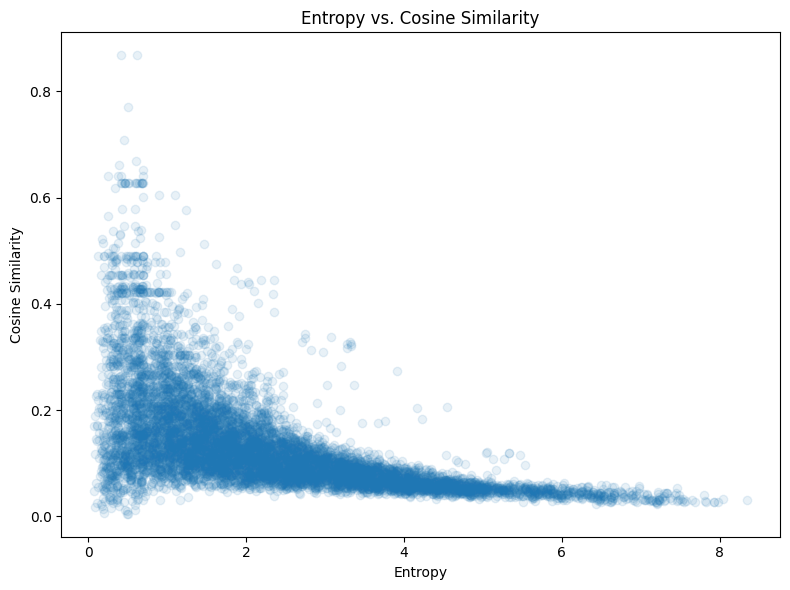

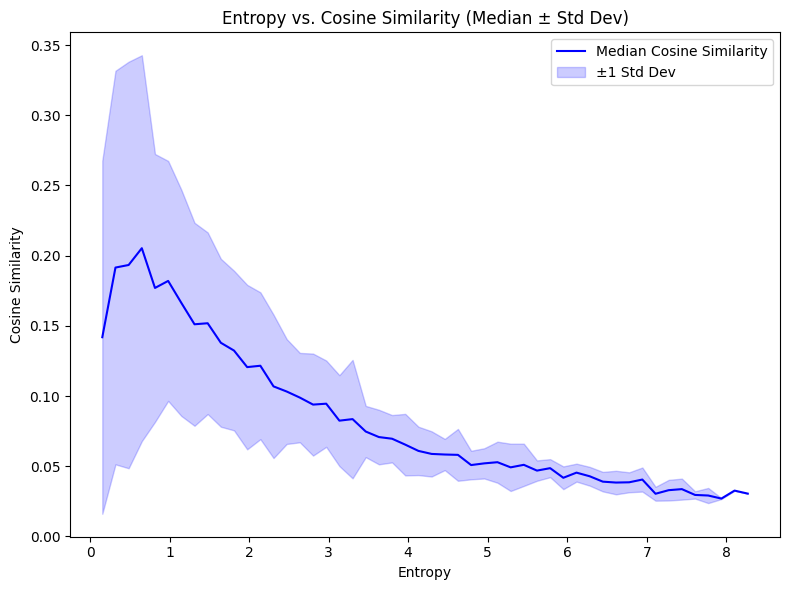

In [24]:
results = load_results()
experiment_results = results["writingprompts"]["Llama-3.1-8B-Instruct"]
# TODO load these in a loop
# The reason we have to precompute the cosines during training is that 
# we need the model embedding layer to produce the vector embeddings. 
# The tokenizer doesnt have that, only the model

import matplotlib.pyplot as plt
import numpy as np

def process_experiment_results(experiment_results, remove_zero_one_points):
    entropies = []
    cosines = []

    for prompt_result in experiment_results["data"]:
        prompt_entropies = prompt_result["entropies"]
        prompt_cosines = prompt_result["cosines"]
        entropies.extend(prompt_entropies)
        cosines.extend(prompt_cosines)
    
    entropies = np.array(entropies, dtype=float)
    cosines = np.array(cosines, dtype=float)

    #mask = (entropies == 0) & np.isnan(cosines)
    #cosines[mask] = 1.0

    
    if remove_zero_one_points:
        mask = ~((entropies == 0) & (cosines == 1))
        entropies = entropies[mask]
        cosines = cosines[mask]

    # compute pearson and spearman
    from scipy.stats import pearsonr
    r, p = pearsonr(entropies, cosines)
    print("pearson coefficient")
    print(r)
    print(p)
    from scipy.stats import spearmanr
    rho, p = spearmanr(entropies, cosines)
    print("Spearman coefficient")
    print(rho)
    print(p)

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(entropies, cosines, alpha=0.1)
    plt.xlabel('Entropy')
    plt.ylabel('Cosine Similarity')
    plt.title('Entropy vs. Cosine Similarity')
    plt.tight_layout()
    plt.show()
    # Create line plot

    from scipy.stats import binned_statistic

    # Assuming entropies and cosines are already numpy arrays
    num_bins = 50
    bin_means, bin_edges, _ = binned_statistic(entropies, cosines, statistic='mean', bins=num_bins)
    bin_medians, _, _ = binned_statistic(entropies, cosines, statistic='median', bins=num_bins)

    # Compute standard deviation per bin
    bin_indices = np.digitize(entropies, bin_edges)
    bin_std = np.zeros(num_bins)
    for i in range(1, num_bins + 1):
        bin_values = cosines[bin_indices == i]
        if len(bin_values) > 0:
            bin_std[i-1] = np.std(bin_values)

    # Bin centers for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, bin_medians, label='Median Cosine Similarity', color='blue')
    plt.fill_between(bin_centers,
                    bin_medians - bin_std,
                    bin_medians + bin_std,
                    color='blue',
                    alpha=0.2,
                    label='±1 Std Dev')
    plt.xlabel('Entropy')
    plt.ylabel('Cosine Similarity')
    plt.title('Entropy vs. Cosine Similarity (Median ± Std Dev)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

process_experiment_results(experiment_results, True)

Dataset: writingprompts Model: Llama-3.1-8B-Instruct
pearson coefficient
-0.5755677712389228
0.0
Spearman coefficient
-0.7046207864401464
0.0


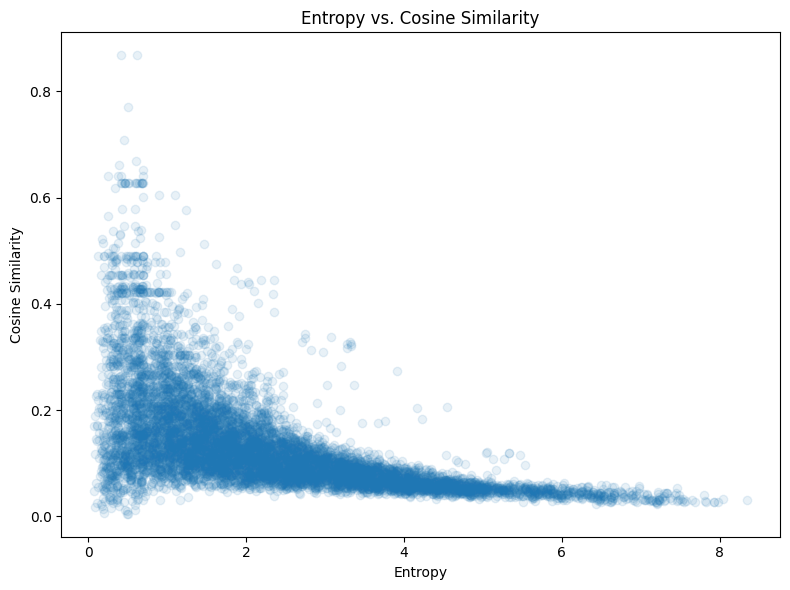

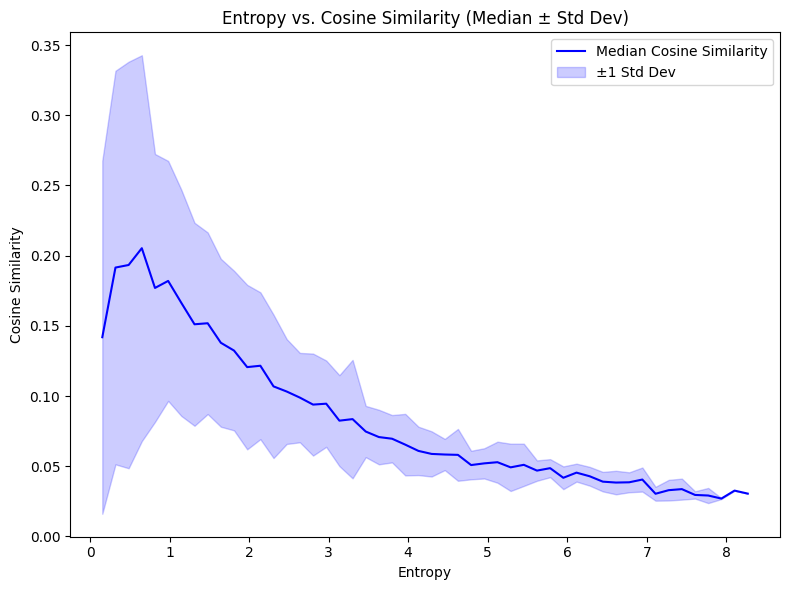

Dataset: gsm8k Model: Llama-3.1-8B-Instruct
pearson coefficient
-0.5755677712389228
0.0
Spearman coefficient
-0.7046207864401464
0.0


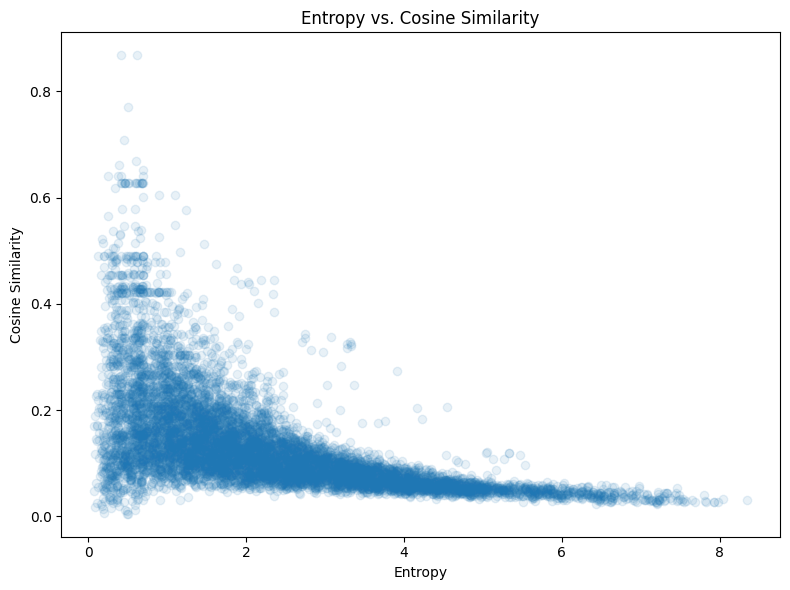

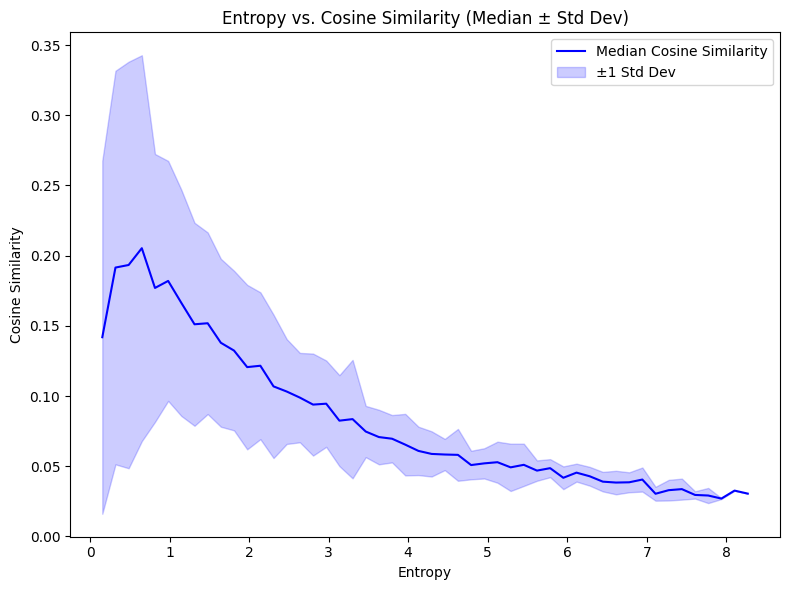

In [ ]:
root_dir = "results/"
results = load_results()
for dataset_name in os.listdir(root_dir):
    dataset_path = os.path.join(root_dir, dataset_name)
    if not os.path.isdir(dataset_path):
        continue

    for model_name in os.listdir(dataset_path):
        model_path = os.path.join(dataset_path, model_name)
        if not os.path.isdir(model_path):
            continue

        print(f"Dataset: {dataset_name} Model: {model_name}")
        experiment_results = results[dataset_name][model_name]
        process_experiment_results(experiment_results, True)